In [1]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot
#from pandas import read_csv, set_option
from pandas import Series, datetime
from pandas.tools.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
eur_usd = pd.read_csv('./data/EUR_USD_exchange_rate.csv', index_col='Time', parse_dates=['Time'])
eur_usd.head()

,Open,High,Low,Close,Volume
Time,,,,,
2010-01-01 00:00:00,1.43283,1.43293,1.43224,1.43293,608600007.1
2010-01-01 00:15:00,1.43285,1.43295,1.43229,1.43275,535600003.2
2010-01-01 00:30:00,1.43280,1.43303,1.43239,1.43281,436299999.2
2010-01-01 00:45:00,1.43285,1.43294,1.43229,1.43276,614299997.3
2010-01-01 01:00:00,1.43287,1.43292,1.43206,1.43282,705300008.8


In [3]:
print(eur_usd.shape)
print(eur_usd.dtypes)

(245444, 5)
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object


In [4]:
print(eur_usd.describe())

                Open           High            Low          Close  \
count  245444.000000  245444.000000  245444.000000  245444.000000   
mean        1.268372       1.268738       1.268003       1.268371   
std         0.112994       0.113017       0.112965       0.112994   
min         1.035580       1.036280       1.035230       1.035600   
25%         1.135350       1.135660       1.134870       1.135348   
50%         1.302350       1.302740       1.302100       1.302350   
75%         1.356560       1.356980       1.356082       1.356552   
max         1.493230       1.493980       1.491850       1.493240   

             Volume  
count  2.454440e+05  
mean   1.624311e+09  
std    2.320694e+09  
min    0.000000e+00  
25%    0.000000e+00  
50%    9.801100e+08  
75%    2.316977e+09  
max    3.779797e+10  


In [21]:
eur_usd_daily =  eur_usd.resample('D', convention='start').mean()
print(eur_usd_daily.shape)
print(eur_usd_daily.dtypes)
eur_usd_daily.head()

(2557, 5)
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object


,Open,High,Low,Close,Volume
Time,,,,,
2010-01-01,1.433060,1.433316,1.432669,1.433058,7.998688e+08
2010-01-02,1.433350,1.433350,1.433350,1.433350,0.000000e+00
2010-01-03,1.433221,1.433288,1.433168,1.433237,3.126667e+07
2010-01-04,1.436392,1.437289,1.435604,1.436509,8.335354e+08
2010-01-05,1.440934,1.441628,1.440109,1.440874,8.321573e+08


In [23]:
Predictors = pd.DataFrame({
    "day7": eur_usd_daily.Open.shift(7),
    "day6": eur_usd_daily.Open.shift(6),
    "day5": eur_usd_daily.Open.shift(5),
    "day4": eur_usd_daily.Open.shift(4),
    "day3": eur_usd_daily.Open.shift(3),
    "day2": eur_usd_daily.Open.shift(2),
    "day1": eur_usd_daily.Open.shift(1),
}).dropna()

In [24]:
Predictors.head()


,day1,day2,day3,day4,day5,day6,day7
Time,,,,,,,
2010-01-08,1.435275,1.436886,1.440934,1.436392,1.433221,1.433350,1.433060
2010-01-09,1.434374,1.435275,1.436886,1.440934,1.436392,1.433221,1.433350
2010-01-10,1.440830,1.434374,1.435275,1.436886,1.440934,1.436392,1.433221
2010-01-11,1.440978,1.440830,1.434374,1.435275,1.436886,1.440934,1.436392
2010-01-12,1.451217,1.440978,1.440830,1.434374,1.435275,1.436886,1.440934


In [25]:
target = pd.DataFrame({'value': eur_usd_daily.Open}).dropna()

In [29]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [60]:
# drops index values if they are not present in both target and Predictors
X = pd.merge(Predictors, target, left_index=True, right_index=True)[Predictors.columns]
y = pd.merge(Predictors, target, left_index=True, right_index=True)[target.columns]

test_size = 0.002
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

In [61]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.01)
 
xgbModel = regressor.fit(X_train,y_train)
y_predicted = xgbModel.predict(X_test)

In [62]:
#print(accuracy_score(y_test, y_predicted))
#pyplot.plot(X_test['Objectivity'])
#pyplot.plot(y_predicted)
test_index = int(len(X)*(1-test_size))
result = pd.DataFrame({
    'test': y_test.value,
    'predicted': y_predicted
},
index = y_test.index)
#pyplot.show()

In [63]:
type(y_predicted)
y_predicted.shape

(6,)

In [64]:
type(y_test)

pandas.core.frame.DataFrame

In [65]:
y_test.head()

,value
Time,
2016-12-26,1.045348
2016-12-27,1.044936
2016-12-28,1.043043
2016-12-29,1.046375
2016-12-30,1.053831


In [66]:
result.shape

(6, 2)

In [67]:
result.head()

,predicted,test
Time,,
2016-12-26,0.98365,1.045348
2016-12-27,0.98365,1.044936
2016-12-28,0.98365,1.043043
2016-12-29,0.98365,1.046375
2016-12-30,0.98365,1.053831


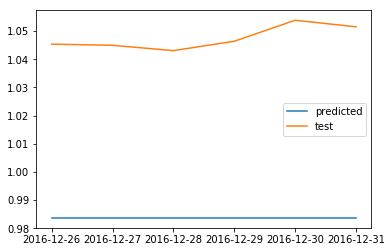

In [68]:
pyplot.plot(result.predicted)
pyplot.plot(result.test)
pyplot.legend()
pyplot.show()

In [69]:
def arrange_data(data, beforeCount)

,Open,High,Low,Close,Volume
Time,,,,,
2010-01-01 00:00:00,1.43283,1.43293,1.43224,1.43293,608600007.1
2010-01-01 00:15:00,1.43285,1.43295,1.43229,1.43275,535600003.2
2010-01-01 00:30:00,1.43280,1.43303,1.43239,1.43281,436299999.2
2010-01-01 00:45:00,1.43285,1.43294,1.43229,1.43276,614299997.3
2010-01-01 01:00:00,1.43287,1.43292,1.43206,1.43282,705300008.8
